### Get notes and parse melodies

1. Iterate over measures
2. Iterate over notes and rests
3. Encode `(pitch_class/rest, beat_type, duration)` and append to `grammars`
4. Build corpus from `list(grammars)`
5. Build vocab from `set(corpus)`
6. Build index lookup dicts from corpus


In [225]:
from music21 import converter, clef, stream, pitch, note, meter, midi
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

In [102]:
midi_stream = converter.parse('bwv-1011-1.mid')
midi_stream = midi_stream[0]
midi_stream.clef = clef.BassClef()

In [28]:
midi_stream.write('musicxml', 'bwv-1011-1.xml')

'/Users/naoya/ds/metis/projects/kojak/johann/bwv-1011-1.xml'

In [193]:
def parse_notes(midi_stream):
    melody_corpus = []

    last_pitch = 1
    chord_buffer = []
    prev_offset = 0.0
    for m in midi_stream.measures(1, None):
        time_sig = m.timeSignature
        for nr in m.flat.notesAndRests:
            offset_loc = nr.offset
            pitch = nr.pitch.pitchClass + 1  if isinstance(nr, note.Note) else 0
            beat_strength = round(nr.beatStrength * 4.0, 0)
            duration = float(nr.quarterLength)

            note_repr = (pitch, beat_strength, duration)
            # Handle chords
            if nr.offset == prev_offset:
                if note_repr[0] > 0:
                    chord_buffer.append(note_repr)
            else:
                if chord_buffer: # Choose tone from chord buffer closest to current note
                    chord_melody_tone = sorted(chord_buffer, key=lambda x: abs(x[0] - pitch))[0]
                    melody_corpus.append(chord_melody_tone)
                melody_corpus.append(note_repr)
                chord_buffer = []
            prev_offset = nr.offset
    
    return melody_corpus


In [194]:
KEY_SIG_OFFSET = 0

def build_corpus(midi_files):
    melody_corpus = []
    for file in midi_files:
        midi_stream = converter.parse(file)
        midi_stream = midi_stream[0]
        key_sig = midi_stream.keySignature
        midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)
        melody_corpus.extend(parse_notes(midi_stream))
    # map indices for constructing matrix representations
    melody_set = set(melody_corpus)
    notes_indices = {note: i for i, note in enumerate(melody_set)}
    indices_notes = {i: note for i, note in enumerate(melody_set)}
    
    return melody_corpus, melody_set, notes_indices, indices_notes
        

In [195]:
midi_files = []
with open('midi_files') as filelist:
    for f in filelist:
        midi_files.append(f.replace('\n', ''))

In [196]:
melody_corpus, melody_set, notes_indices, indices_notes = build_corpus(midi_files)

KeyboardInterrupt: 

In [160]:
len(melody_set)

402

In [161]:
corpus_size = len(melody_set)

In [167]:
corpus_size = len(melody_set)

# cut the corpus into semi-redundant sequences of max_len values
step_size = 5
phrase_len = 50
phrases = []
next_notes = []
for i in range(0, len(melody_corpus) - phrase_len, step_size):
    phrases.append(melody_corpus[i: i + phrase_len])
    next_notes.append(melody_corpus[i + phrase_len])
print('nb sequences:', len(phrases))

# transform data into binary matrices
X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
for i, phrase in enumerate(phrases):
    for j, note in enumerate(phrase):
        X[i, j, notes_indices[note]] = 1
    y[i, notes_indices[next_notes[i]]] = 1

nb sequences: 2845


In [172]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(phrase_len, corpus_size)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(corpus_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.fit(X, y, batch_size=128, nb_epoch=1)

Epoch 1/1
2845/2845 [==============================] - 109s - loss: 5.0664   


In [221]:
def __sample(a, temperature=1.0):
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

def __predict(model, x, indices_notes, diversity):
    preds = model.predict(x, verbose=0)[0]
    next_index = __sample(preds, diversity)
    next_val = indices_notes[next_index]

    return next_val

def generate_sequence(model, seq_len, melody_corpus, melody_set, phrase_len, notes_indices, indices_notes, temperature):
    gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
    start_pos = np.random.randint(0, len(melody_corpus) - phrase_len)
    seed_phrase = melody_corpus[start_pos : start_pos + phrase_len]
    gen_melody = seed_phrase
    
        
    for _ in range(seq_len):
        seed_phrase = gen_melody[-phrase_len:]
        for i, note in enumerate(seed_phrase):
            gen_melody_indices[0, i, notes_indices[note]] = 1
        x = gen_melody_indices
        next_note = __predict(model, x, indices_notes, temperature)
        # seed_phrase.append(next_note)
        gen_melody.append(next_note)
        # seed_phrase = seed_phrase[1:]
        
#     gen_melody = [indices_notes[i] for i in gen_melody_indices]
    return gen_melody
    

In [219]:
gen_melody.shape

(1, 50, 402)

In [248]:
gen_melody = generate_sequence(model, 150, melody_corpus, melody_set, 50, notes_indices, indices_notes, 0.4)

In [249]:
v = stream.Voice()
last_note_duration = 0
for n in gen_melody:
    if n[0] == 0:
        new_note = note.Rest()
    else:
        new_pitch = pitch.Pitch()
        new_pitch.midi = 59.0 + n[0]
        new_note = note.Note(new_pitch)
    new_note.offset = v.highestOffset + last_note_duration
    new_note.duration.quarterLength = n[2]
    last_note_duration = new_note.duration.quarterLength
    v.insert(new_note)

In [251]:
sp = midi.realtime.StreamPlayer(v)
sp.play()

In [69]:
melody[1]

<music21.clef.BassClef>

In [84]:
[(i.pitch.pitchClass, i.measureNumber, i.duration, i.beatStrength) for i in midi_stream.measures(1, None).flat.notesA[:40]]

AttributeError: 'Part' object has no attribute 'notesA'

In [37]:
midi_stream.

NoneType

In [86]:
n = measures[0].flat.notes[0]

In [87]:
n.pitchClass

/Users/naoya/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: Music21DeprecationWarning: Note._getPitchClass was deprecated on May 2014 and will disappear at or after May 2016. use pitch.pitchClass instead
  if __name__ == '__main__':


0

In [94]:
midi_stream[1]
    

<music21.clef.BassClef>

In [103]:
m = midi_stream.measure(1, None)[:5]

TypeError: 'NoneType' object is not subscriptable

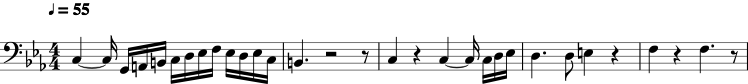

In [104]:
m.show()

In [120]:
f = m.flat

In [139]:
notes = midi_stream.flat.stripTies()

In [140]:
from music21 import graph

In [142]:
g = graph.Plot3DBarsPitchSpaceQuarterLength(
    notes, colors=['b'])

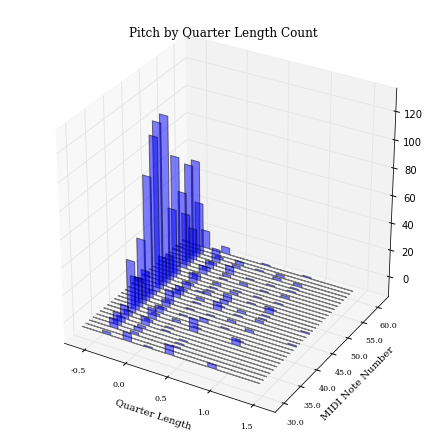

In [143]:
g.process()

In [144]:
notes = midi_stream.flat.notes

In [146]:
len(notes)

1328

In [147]:
notes[0]

<music21.note.Note C>

In [152]:
n = notes[5]

In [161]:
measure_1 = midi_stream.measures(1, None)[5]

In [162]:
len(measure_1.flat.notes)

10

In [163]:
notes_1 = measure_1.flat.notes

In [164]:
print([n for n in notes_1])

[<music21.chord.Chord G2 F3 C2>, <music21.note.Note D>, <music21.note.Note D>, <music21.note.Note C>, <music21.note.Note B->, <music21.note.Note C>, <music21.note.Note E>, <music21.note.Note A->, <music21.note.Note B->, <music21.note.Note C>]


In [165]:
notes_1[0].length

AttributeError: 'Chord' object has no attribute 'length'

In [174]:
notes_1[4].pitch.pitchClass

10

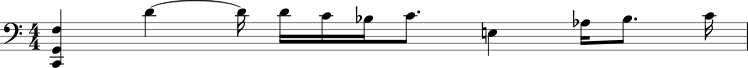

In [171]:
notes_1.show()

In [179]:
note_data = []
for m in midi_stream.measures(1, None):
    notes = m.flat.notes
    for n in notes:
        try:
            note_data.append((n.measureNumber, n.beat, n.beatDuration, n.beatStrength, n.pitch.pitchClass, n.octave))
        except:
            n1 = n
            print(n.)
            break

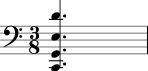

In [180]:
n1.show()

In [181]:
note_data

[(1, 1.0, <music21.duration.Duration 1.0>, 1.0, 0, 3),
 (1, 1.0, <music21.duration.Duration 1.0>, 1.0, 0, 2),
 (1, 2.25, <music21.duration.Duration 1.0>, 0.0625, 7, 2),
 (1, 2.5, <music21.duration.Duration 1.0>, 0.125, 9, 2),
 (1, 2.75, <music21.duration.Duration 1.0>, 0.0625, 11, 2),
 (1, 3.0, <music21.duration.Duration 1.0>, 0.5, 0, 3),
 (1, 3.25, <music21.duration.Duration 1.0>, 0.0625, 2, 3),
 (1, 3.5, <music21.duration.Duration 1.0>, 0.125, 3, 3),
 (1, 3.75, <music21.duration.Duration 1.0>, 0.0625, 5, 3),
 (1, 4.0, <music21.duration.Duration 1.0>, 0.25, 3, 3),
 (1, 4.25, <music21.duration.Duration 1.0>, 0.0625, 2, 3),
 (1, 4.5, <music21.duration.Duration 1.0>, 0.125, 3, 3),
 (1, 4.75, <music21.duration.Duration 1.0>, 0.0625, 0, 3),
 (3, 1.0, <music21.duration.Duration 1.0>, 1.0, 3, 3),
 (3, 1.0, <music21.duration.Duration 1.0>, 1.0, 0, 3),
 (3, 2.0, <music21.duration.Duration 1.0>, 0.25, 0, 2),
 (3, 3.0, <music21.duration.Duration 1.0>, 0.5, 0, 3),
 (3, 4.25, <music21.duration.Dur

In [188]:
note_data[-1]

(222, 2.0, <music21.duration.Duration 0.5>, 0.5, 7, 2)

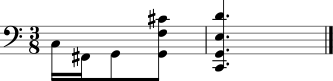

In [184]:
midi_stream.measures(222,223).show()

In [193]:
(n1.measureNumber, n1.beat)#, n1.beatDuration, n1.beatStrength, n1.pitch.pitchClass, n1.octave)

Music21ObjectException: this object does not have a TimeSignature in Sites

In [191]:
type(n1)

music21.chord.Chord

In [197]:
r = note.Rest()
r.pitch

AttributeError: 'Rest' object has no attribute 'pitch'